In [25]:
import Pkg
Pkg.add("Combinatorics")
Pkg.add("Plots")

using Random
using Combinatorics
using Plots

  Resolving package versions...
No Changes to `/opt/julia/environments/v1.5/Project.toml`
No Changes to `/opt/julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/opt/julia/environments/v1.5/Project.toml`
No Changes to `/opt/julia/environments/v1.5/Manifest.toml`
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


## Generate Random Sequences

#### Generating motifs

In [3]:
function generate_motifs(t, k, m, d)
    generated_motifs = Dict()
    neucleotides = ["A","T","G","C"]
    ref_motifs = []
    for i in 1:m
        motif_char = neucleotides[rand(1:length(neucleotides))]
        motif = repeat(motif_char, k)
        deleteat!(neucleotides, findfirst(neucleotides.== motif_char))
        push!(ref_motifs, motif)
        generated_motifs[motif] = []
    end
    for i in 1:t
        for n in 1:m
            motif = ref_motifs[n]
            for j in 1:d
                pos = rand(1:k)
                neucleotide = neucleotides[rand(1:length(neucleotides))]
                motif = motif[1:pos-1] * neucleotide * motif[pos+1:end]
            end
            push!(generated_motifs[ref_motifs[n]], motif)
        end
    end
    return (ref_motifs, generated_motifs)
end

generate_motifs (generic function with 1 method)

#### Generating DNA with implanted motifs

In [4]:
function Arti_DNA(t, l, k, d, gc, m)  
    DNA = []
    position = Dict()
    (ref_motifs, generated_motifs) = generate_motifs(t, k, m, d)
    
    for consensus in ref_motifs
        position[consensus] = Dict()
    end

    for i in 1:t
        m = length(ref_motifs)
        rand_str = randstring("AT", 100-gc)*randstring("GC", gc)
        seq = randstring(rand_str, l)
        push!(DNA, seq)

        positions = collect(1:k:l-k)
        for n in 1:m
            pos = rand(positions)
            motif = generated_motifs[ref_motifs[n]][i]
            DNA[i] = DNA[i][1:pos-1] * motif * DNA[i][pos+k:end]
            deleteat!(positions, findfirst(positions.== pos))
            position[ref_motifs[n]][i] = [motif, pos]
        end
    end
    return(position, ref_motifs, DNA)
end

Arti_DNA (generic function with 1 method)

In [5]:
t=10
l=100
k=8
d=2
gc=50
m=2
(positions, motif, dnas) = Arti_DNA(t, l, k, d, gc, m)
println(positions)
println()
println(motif)
println()
for dna in dnas
   println(dna) 
end

Dict{Any,Any}("AAAAAAAA" => Dict{Any,Any}(7 => Any["AAAAAAGA", 1],4 => Any["ATAAAATA", 9],9 => Any["ATAAGAAA", 1],10 => Any["AAAAAAGT", 33],2 => Any["AAATAAAG", 65],3 => Any["AAAAGATA", 81],5 => Any["AAAGTAAA", 17],8 => Any["AAAATAAG", 81],6 => Any["AAGGAAAA", 17],1 => Any["TTAAAAAA", 1]),"CCCCCCCC" => Dict{Any,Any}(7 => Any["GCCGCCCC", 33],4 => Any["CGCCGCCC", 81],9 => Any["TCCTCCCC", 17],10 => Any["CCCCCTCT", 57],2 => Any["GCCCGCCC", 57],3 => Any["CCCCCCTC", 89],5 => Any["CCGCCGCC", 89],8 => Any["CCCGCTCC", 9],6 => Any["GCCTCCCC", 81],1 => Any["CTGCCCCC", 73]))

Any["CCCCCCCC", "AAAAAAAA"]

TTAAAAAAGCAAGTTGCGGTCCCAGTCTCTTCAGGGCGCTCAAGAGGCACAGCACATTGCTTAAGCTGAGCGCTGCCCCCTCAAGTGCTGGGTGTAATTC
TACCCTACATTAATATCCCGATCACCACGCTATTTTCATAGGTAGCCTGCATCCCCGCCCGCCCAAATAAAGTACCACTTTTCCATGAGTAGAGTCTCCG
TCGAGTTGTGGTGTAACAGACTACTTGACTTACAATATAGTGACACAACTGTTGACCGTGTCCGCTGATGGAGGTGGAAAAAAAGATACCCCCCTCTCAC
ATAGGGATATAAAATAGCTTCTGCATTACTCTCCTTTCCGGCCCTTCTACCCTTTTCCCACCACTTGATGCTGTTATTCTCGCCGCCCGCTCCATTT

## Helper functions

#### Hamming distance between 2 strings

In [6]:
function d_hamm(x,x1)
    i=1
    count = 0
    while i<=length(x)
        if x[i]!=x1[i]
            count+=1
        end
        i+=1
    end
    return count
end

d_hamm (generic function with 1 method)

#### Get C between x and all dna strands

In [7]:
function get_C(x, dna, d)
    Cxsi = Dict()
    t = length(dna)
    l = length(dna[1])
    k = length(x)
    for i in 2:t
        C = Array[]
        for j in 1:(l-k+1)
            xp = dna[i][j:j+k-1]
            if d_hamm(x,xp) <= 2*d
               push!(C, [xp,j])
            end
        end
        Cxsi[i] = C
    end
    return Cxsi
end

get_C (generic function with 1 method)

#### Filter1 logic

In [8]:
function filter1(x, xp, z, d)
    d1 = 0
    d2 = 0
    for i in 1:length(z)
        if x[i] != z[i]
            d1 += 1
        end
        if xp[i] != z[i]
            d2 += 1
        end
    end
    if d1 > 2*d || d2 > 2*d
       return false 
    end
    return true
end

filter1 (generic function with 1 method)

#### Calculating P00 and P10 logic

In [9]:
function p_val(x,x1,z,d)
    i = 1
    count1 = 0
    count2 = 0
    while i<=length(x)
        if x[i]==x1[i]
            if z[i]!=x[i] || z[i]!=x1[i]
                count1+=1
            end
        else
            if z[i]!=x[i]  || z[i]!=x1[i]
                count2+=1
            end
        end
        i+=1
    end
    return [count1,count2]
end

p_val (generic function with 1 method)

#### Filter2 logic

In [10]:
function filter2(x,x1,z,d)
    alpha_range = length(x)-d_hamm(x,x1)
    beta_range = d_hamm(x,x1)

    p_values = p_val(x,x1,z,d)

    for i in 0:alpha_range
        for j in 0:beta_range
            k = 2*i+j+d_hamm(x,x1)
            if k<=2*d
                if abs(p_values[1]-i)+abs(p_values[2]-j)<=d
                    return true
                end
            end
        end
    end
    return false
end

filter2 (generic function with 1 method)

#### Get All Candidate Kmers

In [11]:
function get_all_md_kmers(x, xp, d, ch, k, Md)
    push!(Md, x)
    push!(Md, xp)
    
    pos = collect(combinations(1:k, d))

    for p in pos
        curr = []
        for p_i in p
            push!(curr, x[p_i])
        end
        rem_neucleo = []
        for c in curr
            nucleo = copy(ch)
            push!(rem_neucleo, deleteat!(nucleo, findfirst(nucleo.==c)))
        end
        
        prods = Base.Iterators.product(1)
        for d_i in 1:d
            prods = Base.Iterators.product(prods, rem_neucleo[d_i])
        end
        
        for prod in prods
            for d_i in 1:d
                prod = Tuple(Iterators.flatten(prod))
            end
            prod = prod[2:end]
            seq = x
            i = 1
            for p_i in p
                seq = seq[1:p_i-1] * prod[i] * seq[p_i+1:end]
                if d_hamm(seq, x) <= d && d_hamm(seq, xp) <= d
                    push!(Md, seq)
                end
                i += 1
            end
        end
    end
end

get_all_md_kmers (generic function with 1 method)

#### Verify candidate motif

In [12]:
function verify(y, Cp, r, d)
    final_dict = Dict()
    for (i, C) in Cp
        valid = false
        if i != r
            for yi in C
                if d_hamm(y, yi[1]) <= d
                    final_dict[i] = [yi[1],yi[2]]
                    valid = true
                    break
                end
            end
            if !valid
                return [false,[]]
            end
        end
    end
    return [true,final_dict]
end

verify (generic function with 1 method)

## Pair Motif

In [13]:
function pairmotif(dna, k, d_thres)
    s1 = dna[1]
    M = []
    motif_positions = Dict()
    for i in 1:length(dna[1]) - k + 1
        x = dna[1][i:i+k-1]
        Cxsi = get_C(x, dna, d_thres)
        r = rand(2:length(dna))
        sr = dna[r]
        Cxsr = Cxsi[r]
        Md = Dict()
        for xp in Cxsr
            pair = (x, xp[1])
            Md[pair] = []
            get_all_md_kmers(x, xp[1], d_thres, ['A','T','G','C'], k, Md[pair])

            Cpxsi = Dict()
            for zi in 2:length(dna)
                if zi != r
                    Cpxsi[zi] = []
                    for z in Cxsi[zi]
                        if filter1(x, xp[1], z[1], d_thres) && filter2(x, xp[1], z[1], d_thres)
                            push!(Cpxsi[zi], [z[1],z[2]])
                        end
                    end
                end
            end
            for y in Md[pair]
                verification_results = verify(y, Cpxsi, r, d_thres)
                if verification_results[1] == true
                    if !(y in M)
                        push!(M, y)
                        verification_results[2][1] = [pair[1],i]
                        verification_results[2][r] = [pair[2],xp[2]]
                        motif_positions[y] = verification_results[2]
                    end
                end
            end
            
        end
    end
    return M, motif_positions
end

pairmotif (generic function with 1 method)

In [ ]:
d_thres = 3
(motifs, motif_positions) = pairmotif(dnas, k, d_thres)
println(motifs)
println()
println(motif_positions)

## Helper Functions for Experiment

#### Generate Evaluation Metrics

In [14]:
function run_results(output, implanted, d, t)
    
    #ratio of consensus found
    consensus_motifs_found = 0
    for m in implanted["motifs"]
        if m in output["motifs"]
            consensus_motifs_found += 1
        end 
    end
    consensus_found_rate = consensus_motifs_found/length(implanted["motifs"])
    
    #False Discovery rate
    false_positives = 0
    for m in output["motifs"]
        if !(m in implanted["motifs"])
            false_positives += 1
        end
    end
    false_discovery_rate = false_positives/length(output["motifs"])
    
    #ratio of motifs found in each segment within d hamming distance
    motifs_found_in_segments = 0
    motifs_found_in_segments_position_error = 0
    
    for (consensus, segments) in implanted["motif_positions"]
        for (segment, implants) in segments
            implant =  implants[1]
            implant_pos = implants[2]
            if consensus in keys(output["motif_positions"])
                identified = output["motif_positions"][consensus][segment][1]
                identified_pos = output["motif_positions"][consensus][segment][2]
                if d_hamm(implant, identified) <= d
                    motifs_found_in_segments += 1
                    motifs_found_in_segments_position_error += abs(implant_pos - identified_pos)
                    break
                end
            end
        end
    end
    
    motifs_found_in_segments_ratio = motifs_found_in_segments/(length(implanted["motifs"]) * t)
    motifs_found_in_segments_position_error = motifs_found_in_segments_position_error/(length(implanted["motifs"]) * t)
    
    return (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error)
end

run_results (generic function with 1 method)

## Experiments with Pair Motif

#### Initial control experiments with PairMotif

In [15]:
k_range = collect(8:4:40)
t_range = collect(20:5:50)
l_range = collect(100:100:500)
t = 10
l = 100
d = 1
gc = 50
m = 2
exp_count = 3
d_thres = 2

2

#### Vary the Motif Length

In [17]:
y_val1 = Dict()
y_val1["times"] = []
y_val1["memory"] = []
y_val1["avg_consensus_found_rate_arr"] = []
y_val1["avg_false_discovery_rate_arr"] = []
y_val1["avg_motifs_found_in_segments_ratio_arr"] = []
y_val1["avg_motifs_found_in_segments_position_error_arr"] = []

for k in k_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val1["times"] = [y_val1["times"]; average_time]
    y_val1["memory"] = [y_val1["memory"]; average_memory]
    y_val1["avg_consensus_found_rate_arr"] = [y_val1["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val1["avg_false_discovery_rate_arr"] = [y_val1["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val1["avg_motifs_found_in_segments_ratio_arr"] = [y_val1["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val1["avg_motifs_found_in_segments_position_error_arr"] = [y_val1["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = k_range
x_label = "Length of Motifs"

"Length of Motifs"

## Graph A1

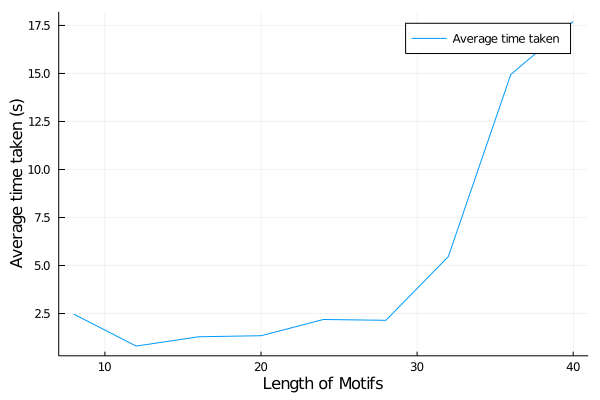

In [26]:
plot(x_val, y_val1["times"], label = "Average time taken", ylabel = "Average time taken (s)", xlabel=x_label)

## Graph A2

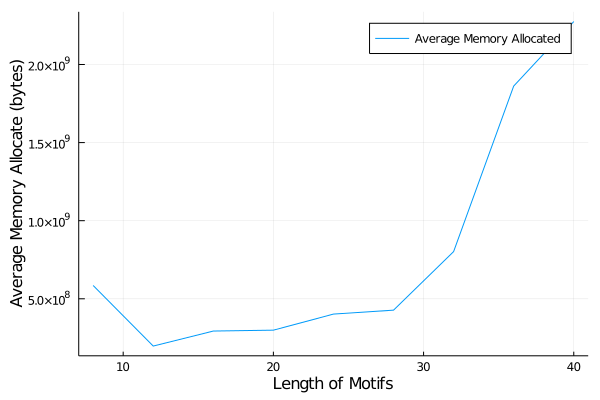

In [27]:
plot(x_val, y_val1["memory"], label = "Average Memory Allocated", ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph A3

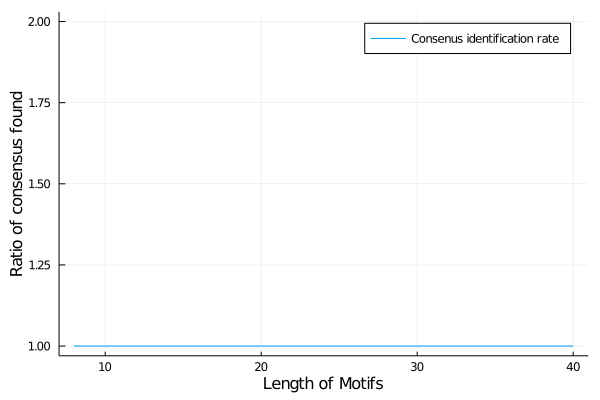

In [28]:
plot(x_val, y_val1["avg_consensus_found_rate_arr"], label = "Consenus identification rate", ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph A4

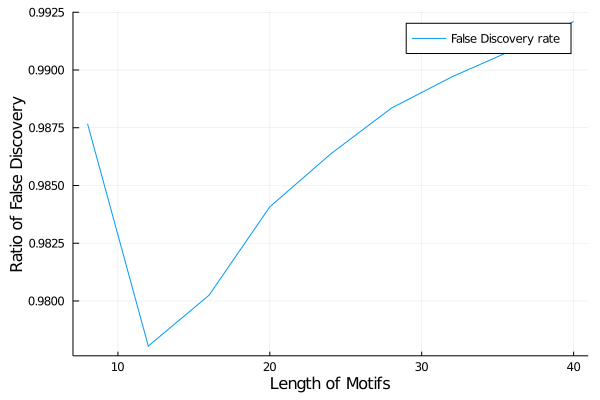

In [29]:
plot(x_val, y_val1["avg_false_discovery_rate_arr"], label = "False Discovery rate", ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph A5

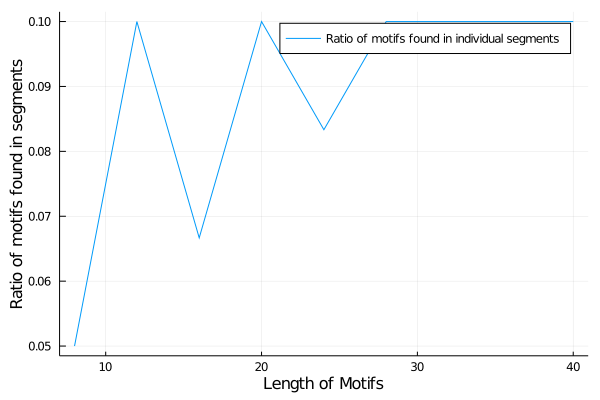

In [30]:
plot(x_val, y_val1["avg_motifs_found_in_segments_ratio_arr"], label = "Ratio of motifs found in individual segments", ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph A6

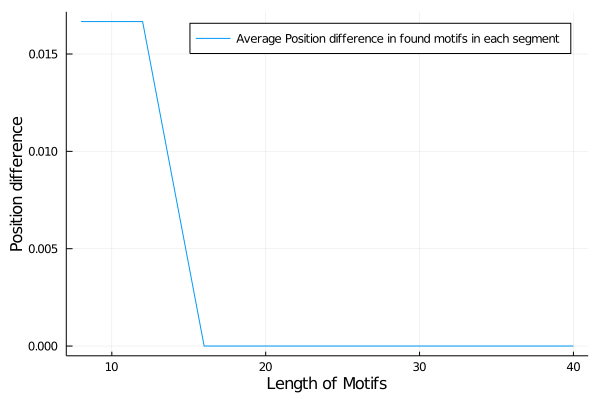

In [31]:
plot(x_val, y_val1["avg_motifs_found_in_segments_position_error_arr"], label = "Average Position difference in found motifs in each segment", ylabel = "Position difference", xlabel=x_label)

#### Varying the number of segments

In [57]:
k = 8

y_val2 = Dict()
y_val2["times"] = []
y_val2["memory"] = []
y_val2["avg_consensus_found_rate_arr"] = []
y_val2["avg_false_discovery_rate_arr"] = []
y_val2["avg_motifs_found_in_segments_ratio_arr"] = []
y_val2["avg_motifs_found_in_segments_position_error_arr"] = []

for t in t_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val2["times"] = [y_val2["times"]; average_time]
    y_val2["memory"] = [y_val2["memory"]; average_memory]
    y_val2["avg_consensus_found_rate_arr"] = [y_val2["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val2["avg_false_discovery_rate_arr"] = [y_val2["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val2["avg_motifs_found_in_segments_ratio_arr"] = [y_val2["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val2["avg_motifs_found_in_segments_position_error_arr"] = [y_val2["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = t_range
x_label = "Number of segments"

"Number of segments"

## Graph A7

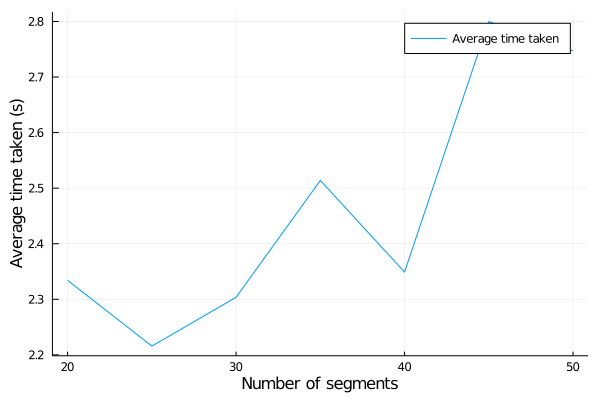

In [58]:
plot(x_val, y_val2["times"], label = "Average time taken", ylabel = "Average time taken (s)", xlabel=x_label)

## Graph A8

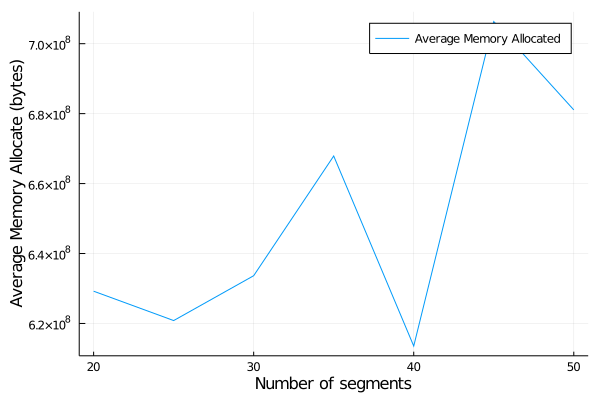

In [59]:
plot(x_val, y_val2["memory"], label = "Average Memory Allocated", ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph A9

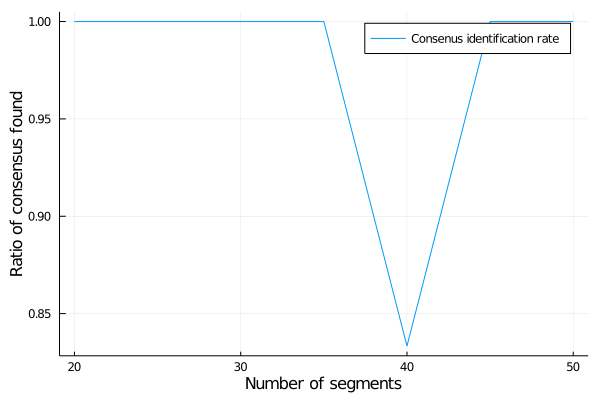

In [60]:
plot(x_val, y_val2["avg_consensus_found_rate_arr"], label = "Consenus identification rate", ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph A10

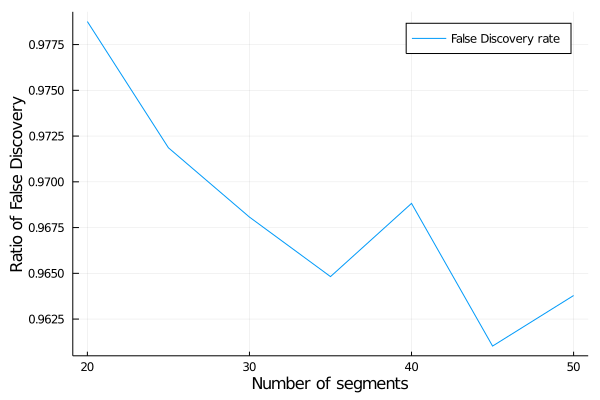

In [61]:
plot(x_val, y_val2["avg_false_discovery_rate_arr"], label = "False Discovery rate", ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph A11

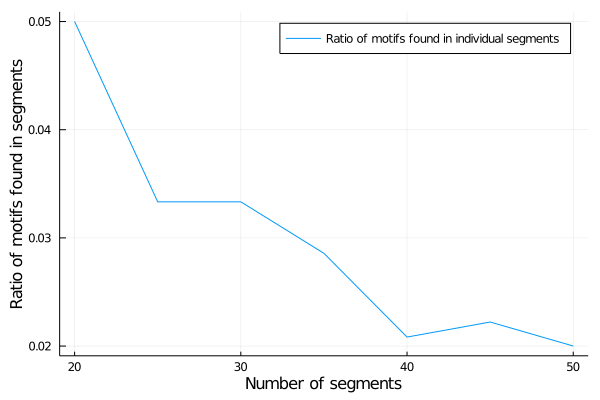

In [62]:
plot(x_val, y_val2["avg_motifs_found_in_segments_ratio_arr"], label = "Ratio of motifs found in individual segments", ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph A12

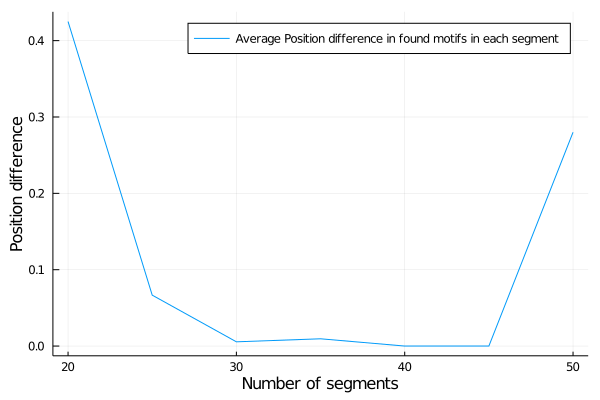

In [63]:
plot(x_val, y_val2["avg_motifs_found_in_segments_position_error_arr"], label = "Average Position difference in found motifs in each segment", ylabel = "Position difference", xlabel=x_label)

#### Varying the length of DNA

In [66]:
t = 10

y_val3 = Dict()
y_val3["times"] = []
y_val3["memory"] = []
y_val3["avg_consensus_found_rate_arr"] = []
y_val3["avg_false_discovery_rate_arr"] = []
y_val3["avg_motifs_found_in_segments_ratio_arr"] = []
y_val3["avg_motifs_found_in_segments_position_error_arr"] = []

for l in l_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val3["times"] = [y_val3["times"]; average_time]
    y_val3["memory"] = [y_val3["memory"]; average_memory]
    y_val3["avg_consensus_found_rate_arr"] = [y_val3["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val3["avg_false_discovery_rate_arr"] = [y_val3["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val3["avg_motifs_found_in_segments_ratio_arr"] = [y_val3["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val3["avg_motifs_found_in_segments_position_error_arr"] = [y_val3["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = l_range
x_label = "Length of DNA segments"

"Length of DNA segments"

## Graph A13

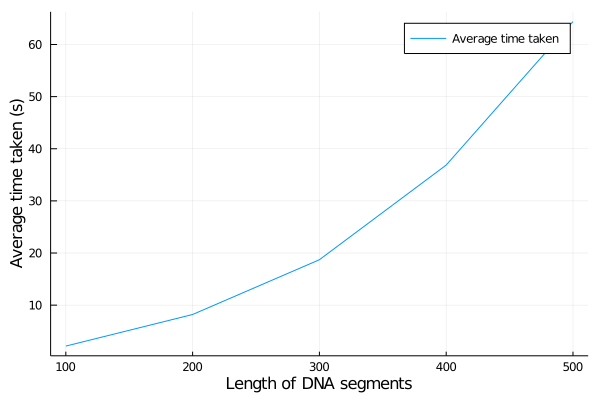

In [67]:
plot(x_val, y_val3["times"], label = "Average time taken", ylabel = "Average time taken (s)", xlabel=x_label)

## Graph A14

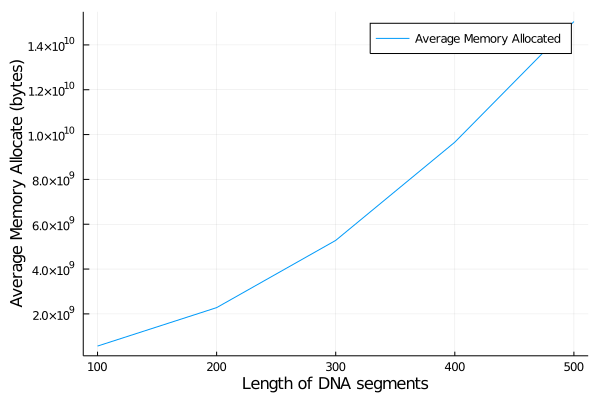

In [68]:
plot(x_val, y_val3["memory"], label = "Average Memory Allocated", ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph A15

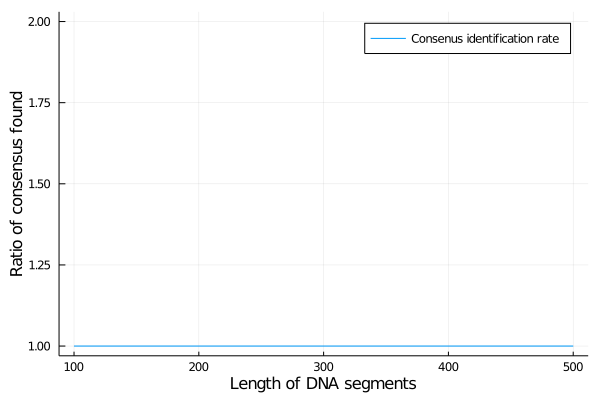

In [69]:
plot(x_val, y_val3["avg_consensus_found_rate_arr"], label = "Consenus identification rate", ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph A16

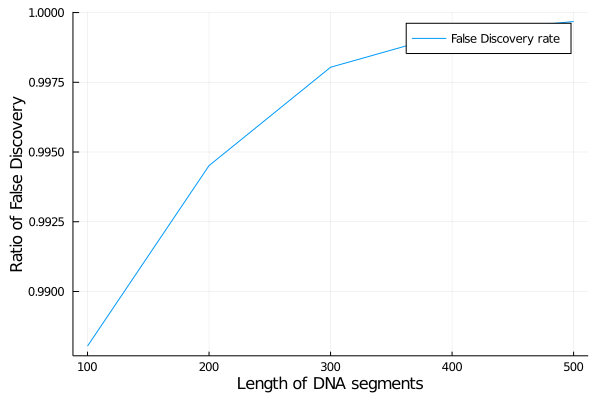

In [70]:
plot(x_val, y_val3["avg_false_discovery_rate_arr"], label = "False Discovery rate", ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph A17

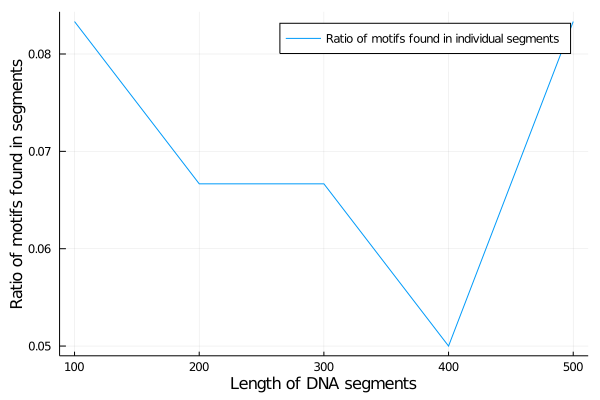

In [71]:
plot(x_val, y_val3["avg_motifs_found_in_segments_ratio_arr"], label = "Ratio of motifs found in individual segments", ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph A18

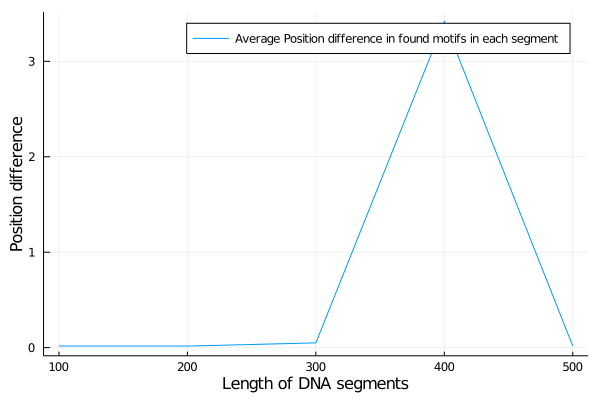

In [72]:
plot(x_val, y_val3["avg_motifs_found_in_segments_position_error_arr"], label = "Average Position difference in found motifs in each segment", ylabel = "Position difference", xlabel=x_label)

## Faster Pair Motif

#### Initial Screening for S1

In [73]:
function init_screen(DNA, k, n, use_prob)
    l = length(DNA)
    c_A = 0
    c_C = 0
    c_G = 0
    c_T = 0
    nucleo = ["ACGT"]
    for j in 1:l
        if DNA[j] == nucleo[1][1]
            c_A = c_A + 1 
        elseif DNA[j] == nucleo[1][2]
            c_C = c_C + 1
        elseif DNA[j] == nucleo[1][3]
            c_G = c_G + 1
        elseif DNA[j] == nucleo[1][4]
            c_T = c_T + 1
        end
    end
    pro_A = c_A/(c_A + c_C + c_G + c_T)
    pro_C = c_C/(c_A + c_C + c_G + c_T)
    pro_G = c_G/(c_A + c_C + c_G + c_T)
    pro_T = c_T/(c_A + c_C + c_G + c_T)
    pro = []
    D = Dict()
    for j in 1:(l-k+1)
        if use_prob == true
            prob = 1
            corr_motif = DNA[j:j+(k-1)]
            for h in 1:k
                if DNA[j+h-1] == nucleo[1][1]
                    prob = prob*pro_A
                elseif DNA[j+h-1] == nucleo[1][2]
                    prob = prob*pro_C
                elseif DNA[j+h-1] == nucleo[1][3]
                    prob = prob*pro_G
                elseif DNA[j+h-1] == nucleo[1][4]
                    prob = prob*pro_T
                end
            end
            push!(pro, prob)
            if prob in keys(D)
                push!(D[prob], [corr_motif,j])
            else
                D[prob] = [[corr_motif,j]]
            end
        else
            prob = 0
            corr_motif = DNA[j:j+(k-1)]
            for h in 1:k
                if DNA[j+h-1] == nucleo[1][1]
                    prob = prob - pro_A*log2(pro_A)
                elseif DNA[j+h-1] == nucleo[1][2]
                    prob = prob - pro_C*log2(pro_C)
                elseif DNA[j+h-1] == nucleo[1][3]
                    prob = prob - pro_G*log2(pro_G)
                elseif DNA[j+h-1] == nucleo[1][4]
                    prob = prob - pro_T*log2(pro_T)
                end
            end
            push!(pro, prob)
            if prob in keys(D)
                push!(D[prob], [corr_motif,j])
            else
                D[prob] = [[corr_motif,j]]
            end
        end
    end
    cand_motif = []
    pro = sort(unique(pro), rev=true)
    i_n = 1
    for i in pro
        for j in 1:length(D[i])
            push!(cand_motif, D[i][j])
        end
        i_n += 1
        if n != -1 && i_n == n
            break
        end
    end
    return(cand_motif)
end

init_screen (generic function with 1 method)

#### Pair Motif using Initial Screening

In [74]:
function pairmotif_faster(dna, k, expected_n, use_prob, d_thres)
    s1 = dna[1]
    M = []
    motif_positions = Dict()
    X = init_screen(s1, k, expected_n, use_prob)
    for (x,i) in X
        Cxsi = get_C(x, dna, d_thres)
        r = rand(2:length(dna))
        sr = dna[r]
        Cxsr = Cxsi[r]
        Md = Dict()
        for xp in Cxsr
            pair = (x, xp[1])
            Md[pair] = []
            get_all_md_kmers(x, xp[1], d_thres, ['A','T','G','C'], k, Md[pair])
            
            Cpxsi = Dict()
            for zi in 2:length(dna)
                if zi != r
                    Cpxsi[zi] = []
                    for z in Cxsi[zi]
                        if filter1(x, xp[1], z[1], d_thres) && filter2(x, xp[1], z[1], d_thres)
                            push!(Cpxsi[zi], [z[1],z[2]])
                        end
                    end
                end
            end
            for y in Md[pair]
                verification_results = verify(y, Cpxsi, r, d_thres)
                if verification_results[1] == true
                    if !(y in M)
                        push!(M, y)
                        verification_results[2][1] = [pair[1],i]
                        verification_results[2][r] = [pair[2],xp[2]]
                        motif_positions[y] = verification_results[2]
                    end
                end
            end
            
        end
    end
    return M, motif_positions
end

pairmotif_faster (generic function with 1 method)

In [ ]:
d_thres = 3
expected_n = 60
use_prob = true
(motifs, motif_positions) = pairmotif_faster(dnas, k, expected_n, use_prob, d_thres)
println(motifs)
println()
println(motif_positions)

## Experiments with Faster Pair Motif

In [75]:
k_range = collect(8:4:40)
t_range = collect(20:5:50)
l_range = collect(100:100:500)
t = 10
l = 100
d = 1
gc = 50
m = 2
exp_count = 3
d_thres = 2
expected_n = 30
use_prob = true

true

#### Vary the Motif Length

In [76]:
y_val21 = Dict()
y_val21["times"] = []
y_val21["memory"] = []
y_val21["avg_consensus_found_rate_arr"] = []
y_val21["avg_false_discovery_rate_arr"] = []
y_val21["avg_motifs_found_in_segments_ratio_arr"] = []
y_val21["avg_motifs_found_in_segments_position_error_arr"] = []

for k in k_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif_faster(dna, k, expected_n, use_prob, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val21["times"] = [y_val21["times"]; average_time]
    y_val21["memory"] = [y_val21["memory"]; average_memory]
    y_val21["avg_consensus_found_rate_arr"] = [y_val21["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val21["avg_false_discovery_rate_arr"] = [y_val21["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val21["avg_motifs_found_in_segments_ratio_arr"] = [y_val21["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val21["avg_motifs_found_in_segments_position_error_arr"] = [y_val21["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = k_range
x_label = "Length of Motifs"

"Length of Motifs"

## Graph B1

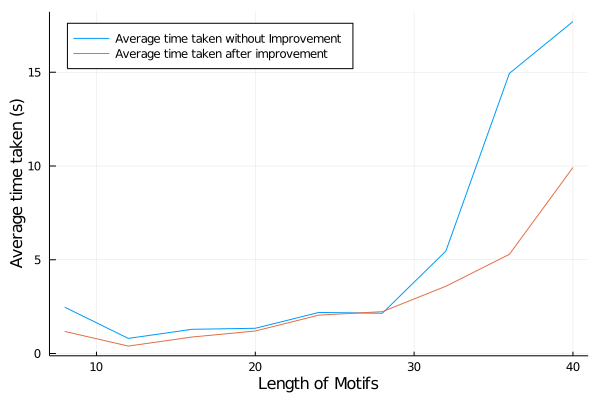

In [79]:
plot(x_val, [y_val1["times"],y_val21["times"]], label = ["Average time taken without Improvement" "Average time taken after improvement"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph B2

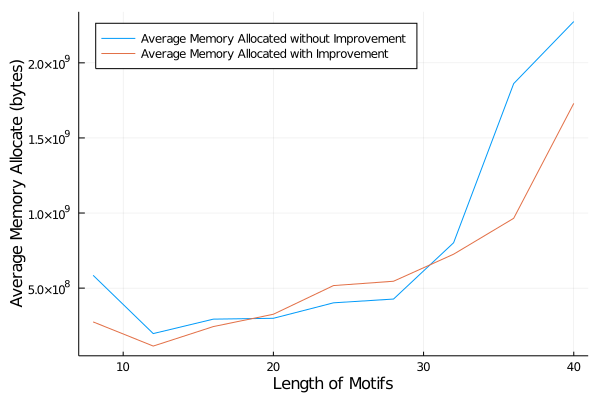

In [80]:
plot(x_val, [y_val1["memory"],y_val21["memory"]], label = ["Average Memory Allocated without Improvement" "Average Memory Allocated with Improvement"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph B3

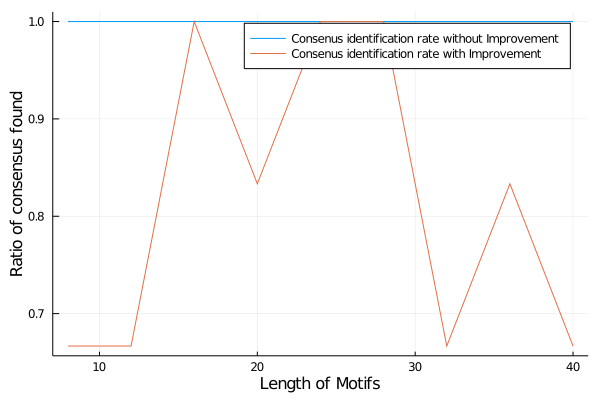

In [82]:
plot(x_val, [y_val1["avg_consensus_found_rate_arr"], y_val21["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate without Improvement" "Consenus identification rate with Improvement"], ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph B4

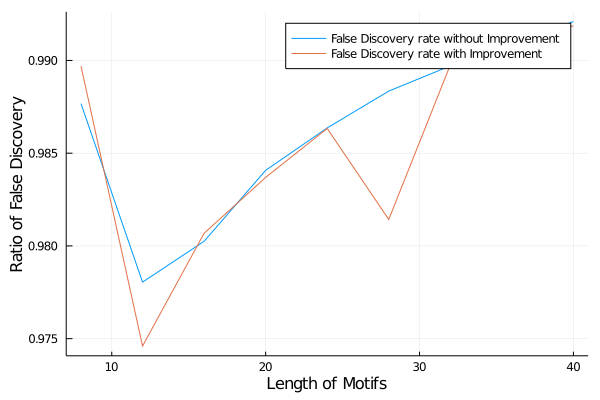

In [83]:
plot(x_val, [y_val1["avg_false_discovery_rate_arr"],y_val21["avg_false_discovery_rate_arr"]], label = ["False Discovery rate without Improvement" "False Discovery rate with Improvement"], ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph B5

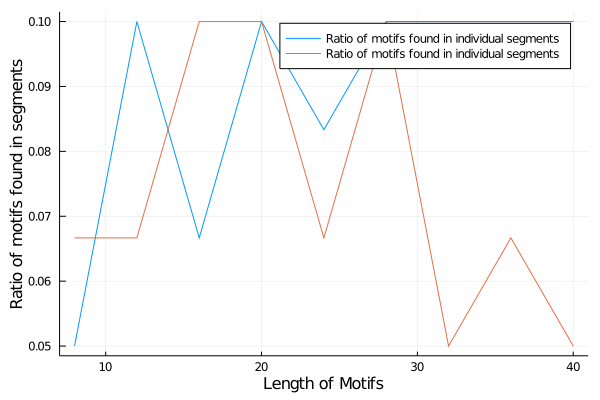

In [55]:
plot(x_val, [y_val1["avg_motifs_found_in_segments_ratio_arr"],y_val21["avg_motifs_found_in_segments_ratio_arr"]], label = "Ratio of motifs found in individual segments", ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph B6

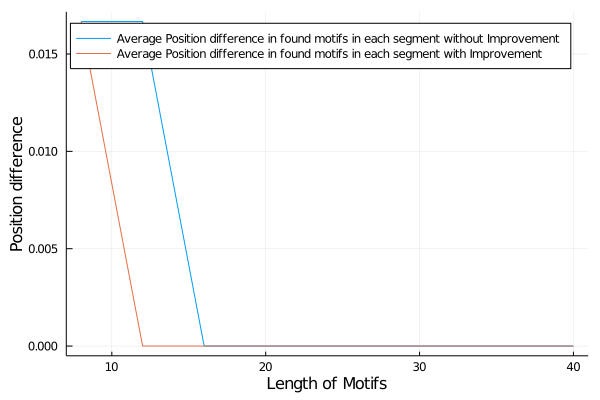

In [84]:
plot(x_val, [y_val1["avg_motifs_found_in_segments_position_error_arr"],y_val21["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment without Improvement" "Average Position difference in found motifs in each segment with Improvement"], ylabel = "Position difference", xlabel=x_label)

#### Number of Segments

In [85]:
k = 8

y_val22 = Dict()
y_val22["times"] = []
y_val22["memory"] = []
y_val22["avg_consensus_found_rate_arr"] = []
y_val22["avg_false_discovery_rate_arr"] = []
y_val22["avg_motifs_found_in_segments_ratio_arr"] = []
y_val22["avg_motifs_found_in_segments_position_error_arr"] = []

for t in t_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif_faster(dna, k, expected_n, use_prob, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val22["times"] = [y_val22["times"]; average_time]
    y_val22["memory"] = [y_val22["memory"]; average_memory]
    y_val22["avg_consensus_found_rate_arr"] = [y_val22["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val22["avg_false_discovery_rate_arr"] = [y_val22["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val22["avg_motifs_found_in_segments_ratio_arr"] = [y_val22["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val22["avg_motifs_found_in_segments_position_error_arr"] = [y_val22["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = t_range
x_label = "Number of segments"

"Number of segments"

## Graph B7

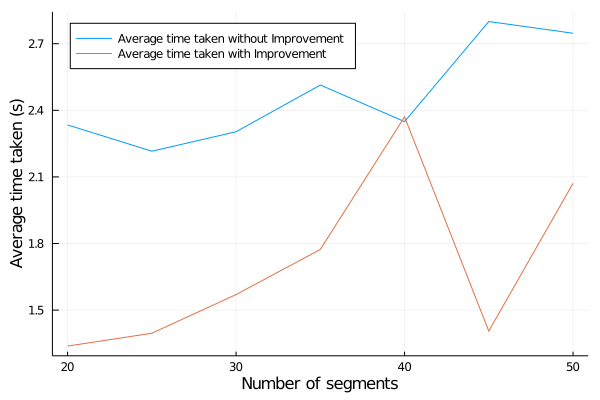

In [87]:
plot(x_val, [y_val2["times"],y_val22["times"]], label = ["Average time taken without Improvement" "Average time taken with Improvement"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph B8

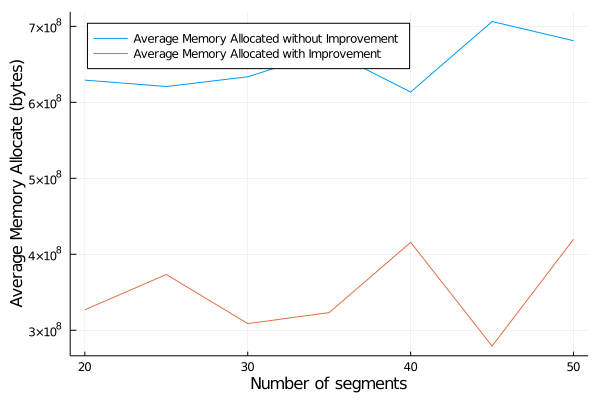

In [89]:
plot(x_val, [y_val2["memory"], y_val22["memory"]], label = ["Average Memory Allocated without Improvement" "Average Memory Allocated with Improvement"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph B9

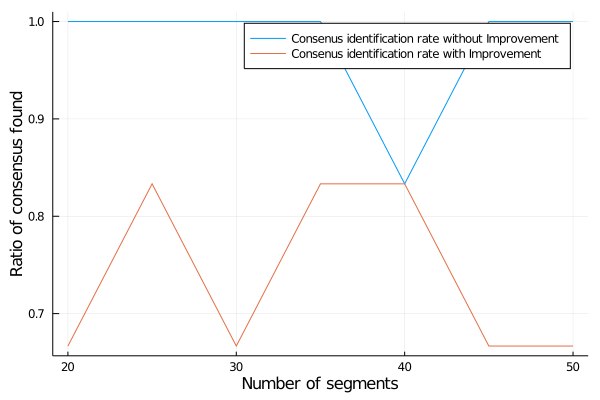

In [90]:
plot(x_val, [y_val2["avg_consensus_found_rate_arr"], y_val22["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate without Improvement" "Consenus identification rate with Improvement"], ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph B10

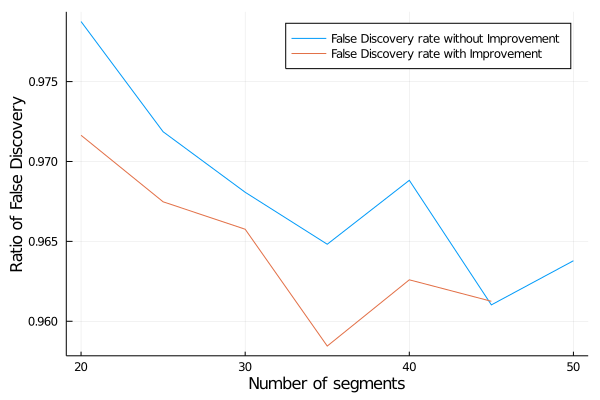

In [91]:
plot(x_val, [y_val2["avg_false_discovery_rate_arr"], y_val22["avg_false_discovery_rate_arr"]], label = ["False Discovery rate without Improvement" "False Discovery rate with Improvement"], ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph B11

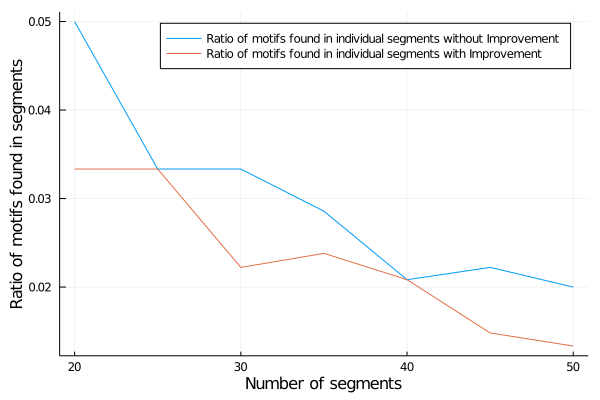

In [92]:
plot(x_val, [y_val2["avg_motifs_found_in_segments_ratio_arr"], y_val22["avg_motifs_found_in_segments_ratio_arr"]], label = ["Ratio of motifs found in individual segments without Improvement" "Ratio of motifs found in individual segments with Improvement"], ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph B12

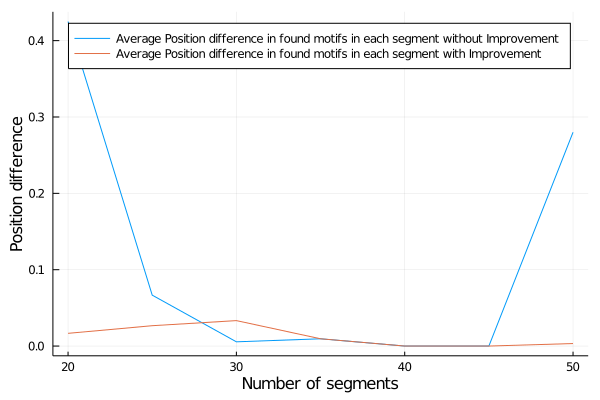

In [94]:
plot(x_val, [y_val2["avg_motifs_found_in_segments_position_error_arr"], y_val22["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment without Improvement" "Average Position difference in found motifs in each segment with Improvement"], ylabel = "Position difference", xlabel=x_label)

#### Varying the DNA Length

In [95]:
t = 10

y_val23 = Dict()
y_val23["times"] = []
y_val23["memory"] = []
y_val23["avg_consensus_found_rate_arr"] = []
y_val23["avg_false_discovery_rate_arr"] = []
y_val23["avg_motifs_found_in_segments_ratio_arr"] = []
y_val23["avg_motifs_found_in_segments_position_error_arr"] = []

for l in l_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif_faster(dna, k, expected_n, use_prob, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val23["times"] = [y_val23["times"]; average_time]
    y_val23["memory"] = [y_val23["memory"]; average_memory]
    y_val23["avg_consensus_found_rate_arr"] = [y_val23["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val23["avg_false_discovery_rate_arr"] = [y_val23["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val23["avg_motifs_found_in_segments_ratio_arr"] = [y_val23["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val23["avg_motifs_found_in_segments_position_error_arr"] = [y_val23["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = l_range
x_label = "Length of DNA segments"

"Length of DNA segments"

## Graph B13

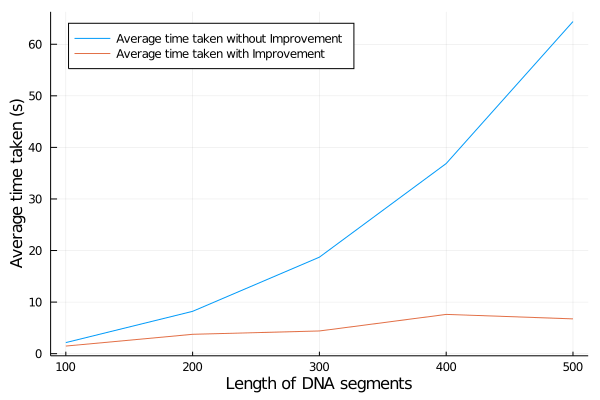

In [97]:
plot(x_val, [y_val3["times"], y_val23["times"]], label = ["Average time taken without Improvement" "Average time taken with Improvement"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph B14

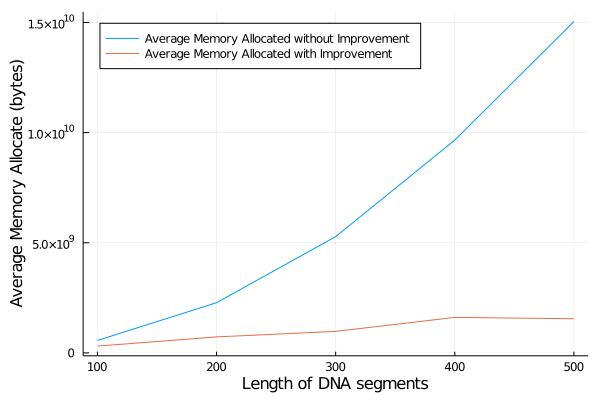

In [99]:
plot(x_val, [y_val3["memory"], y_val23["memory"]], label = ["Average Memory Allocated without Improvement" "Average Memory Allocated with Improvement"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph B15

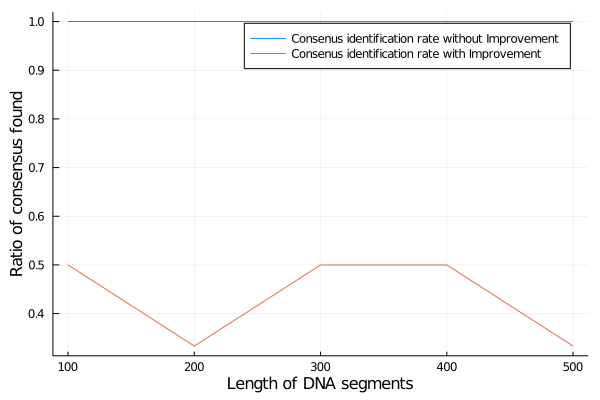

In [100]:
plot(x_val, [y_val3["avg_consensus_found_rate_arr"], y_val23["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate without Improvement" "Consenus identification rate with Improvement"], ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph B16

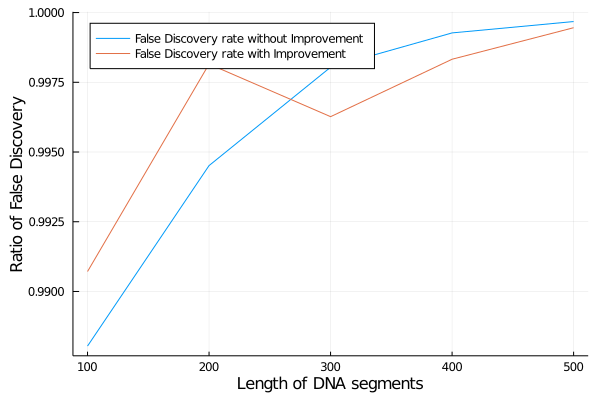

In [102]:
plot(x_val, [y_val3["avg_false_discovery_rate_arr"], y_val23["avg_false_discovery_rate_arr"]], label = ["False Discovery rate without Improvement" "False Discovery rate with Improvement"], legend=:topleft, ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph B17

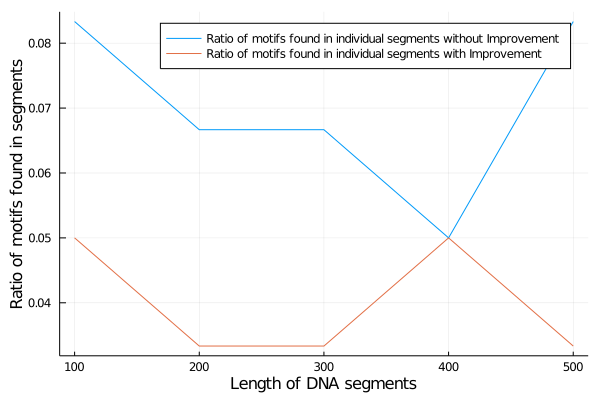

In [103]:
plot(x_val, [y_val3["avg_motifs_found_in_segments_ratio_arr"], y_val23["avg_motifs_found_in_segments_ratio_arr"]], label = ["Ratio of motifs found in individual segments without Improvement" "Ratio of motifs found in individual segments with Improvement"], ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph B18

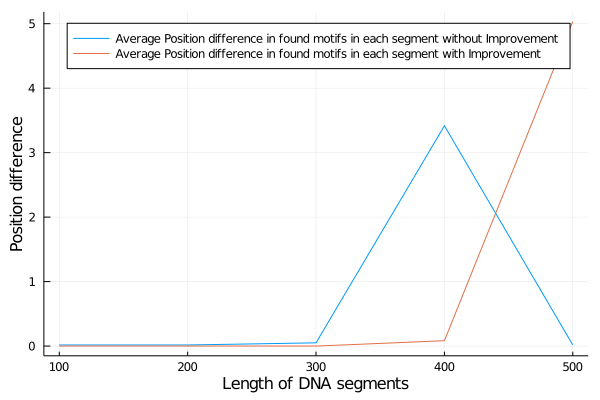

In [104]:
plot(x_val, [y_val3["avg_motifs_found_in_segments_position_error_arr"], y_val23["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment without Improvement" "Average Position difference in found motifs in each segment with Improvement"], ylabel = "Position difference", xlabel=x_label)

## Apriori + Pair Motif

#### Apriori Function

In [105]:
function apriori(motifs)
    if length(motifs)==0
        return []
    end
    index_count = 1
    while index_count<=length(motifs[1])
        dict = Dict()
        total_length = length(motifs)
        for i in 1:length(motifs)
            if haskey(dict,motifs[i][1:index_count])
                dict[motifs[i][1:index_count]]+=1
            else
                dict[motifs[i][1:index_count]]=1
            end
        end
        new_list = []
        keys_values = keys(dict)
        condition = false
        for i in keys_values
            consideration_val = dict[i]/total_length
            if consideration_val>1/total_length
                condition = true
                for all in 1:length(motifs)
                    if motifs[all][1:index_count]==i
                        push!(new_list,motifs[all])
                    end
                end
            end
        end
        if condition==false
            return motifs
        end
        motifs = new_list
        index_count+=1
    end
    return motifs
end

apriori (generic function with 1 method)

## Experiments with PairMotif + Apriori

In [106]:
k_range = collect(8:4:40)
t_range = collect(20:5:50)
l_range = collect(100:100:500)
t = 10
l = 100
d = 1
gc = 50
m = 2
exp_count = 3
d_thres = 2
expected_n = 60
use_prob = true

true

#### Vary the Motif Length

In [109]:
y_val31 = Dict()
y_val31["times"] = []
y_val31["memory"] = []
y_val31["avg_consensus_found_rate_arr"] = []
y_val31["avg_false_discovery_rate_arr"] = []
y_val31["avg_motifs_found_in_segments_ratio_arr"] = []
y_val31["avg_motifs_found_in_segments_position_error_arr"] = []

for k in k_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        (motifs, time_apriori, bytes_apriori) = @timed(apriori(motifs))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        
        time += time_apriori
        bytes += bytes_apriori
        
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val31["times"] = [y_val31["times"]; average_time]
    y_val31["memory"] = [y_val31["memory"]; average_memory]
    y_val31["avg_consensus_found_rate_arr"] = [y_val31["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val31["avg_false_discovery_rate_arr"] = [y_val31["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val31["avg_motifs_found_in_segments_ratio_arr"] = [y_val31["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val31["avg_motifs_found_in_segments_position_error_arr"] = [y_val31["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = k_range
x_label = "Length of Motifs"

"Length of Motifs"

## Graph C1

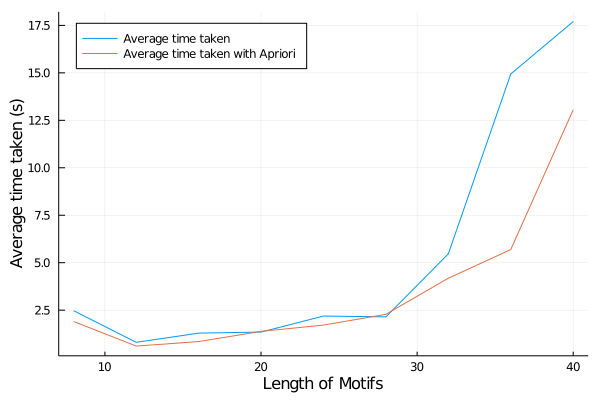

In [111]:
plot(x_val, [y_val1["times"],y_val31["times"]], label = ["Average time taken" "Average time taken with Apriori"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph C2

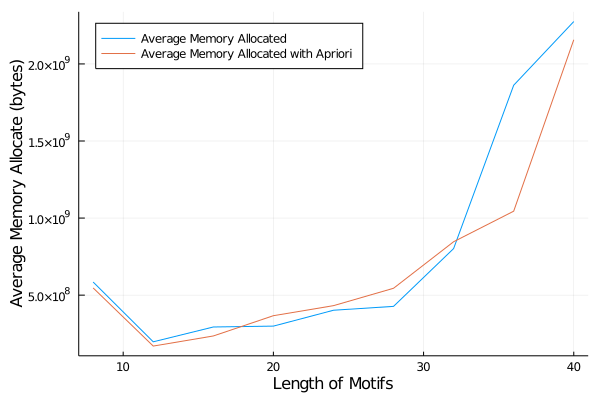

In [112]:
plot(x_val, [y_val1["memory"],y_val31["memory"]], label = ["Average Memory Allocated" "Average Memory Allocated with Apriori"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph C3

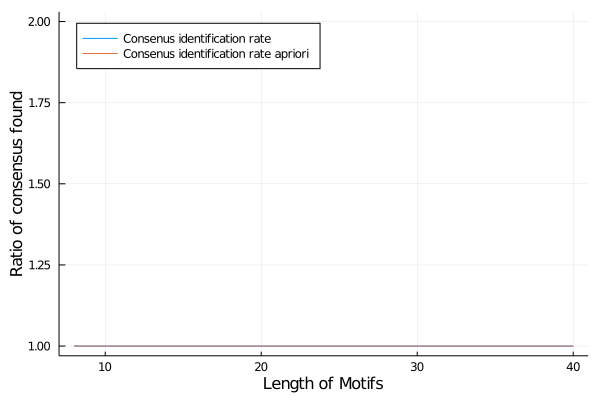

In [114]:
plot(x_val, [y_val1["avg_consensus_found_rate_arr"],y_val31["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate" "Consenus identification rate apriori"], legend=:topleft, ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph C4

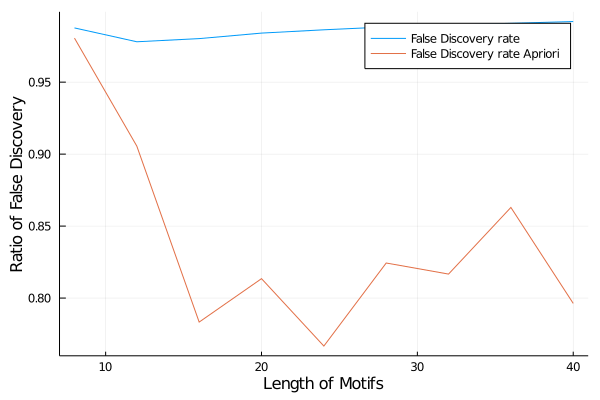

In [115]:
plot(x_val, [y_val1["avg_false_discovery_rate_arr"], y_val31["avg_false_discovery_rate_arr"]], label = ["False Discovery rate" "False Discovery rate Apriori"], ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph C5

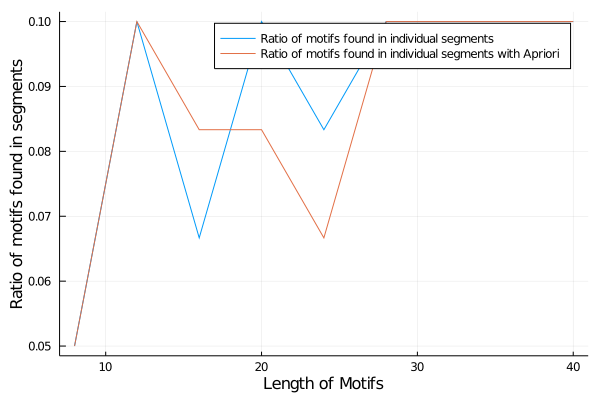

In [116]:
plot(x_val, [y_val1["avg_motifs_found_in_segments_ratio_arr"],y_val31["avg_motifs_found_in_segments_ratio_arr"]], label = ["Ratio of motifs found in individual segments" "Ratio of motifs found in individual segments with Apriori"], ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph C6

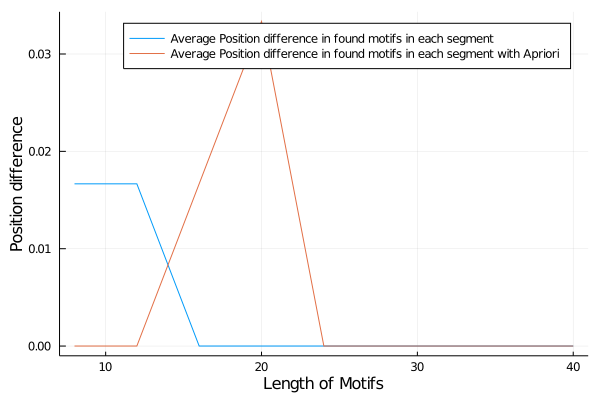

In [117]:
plot(x_val, [y_val1["avg_motifs_found_in_segments_position_error_arr"] y_val31["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment" "Average Position difference in found motifs in each segment with Apriori"], ylabel = "Position difference", xlabel=x_label)

#### Vary the Number of Segments

In [118]:
k = 8

y_val32 = Dict()
y_val32["times"] = []
y_val32["memory"] = []
y_val32["avg_consensus_found_rate_arr"] = []
y_val32["avg_false_discovery_rate_arr"] = []
y_val32["avg_motifs_found_in_segments_ratio_arr"] = []
y_val32["avg_motifs_found_in_segments_position_error_arr"] = []

for t in t_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (motifs, time_apriori, bytes_apriori) = @timed(apriori(motifs))
        
        time += time_apriori
        bytes += bytes_apriori
        
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val32["times"] = [y_val32["times"]; average_time]
    y_val32["memory"] = [y_val32["memory"]; average_memory]
    y_val32["avg_consensus_found_rate_arr"] = [y_val32["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val32["avg_false_discovery_rate_arr"] = [y_val32["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val32["avg_motifs_found_in_segments_ratio_arr"] = [y_val32["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val32["avg_motifs_found_in_segments_position_error_arr"] = [y_val32["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = t_range
x_label = "Number of segments"

"Number of segments"

## Graph C7

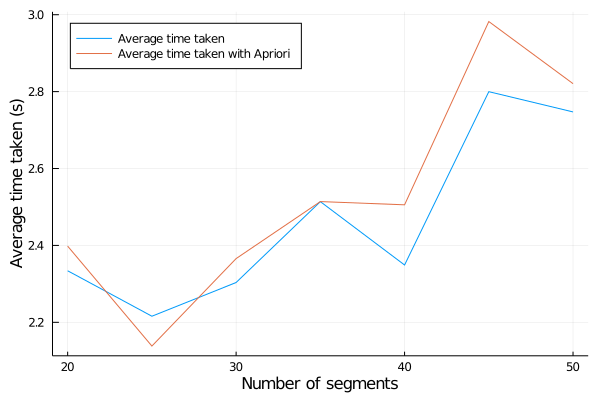

In [120]:
plot(x_val, [y_val2["times"], y_val32["times"]], label = ["Average time taken" "Average time taken with Apriori"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph C8

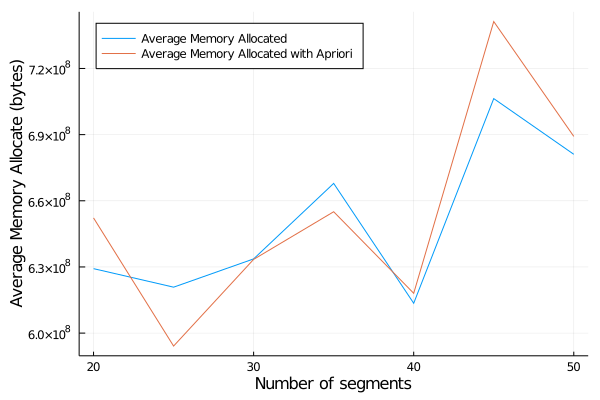

In [122]:
plot(x_val, [y_val2["memory"], y_val32["memory"]], label = ["Average Memory Allocated" "Average Memory Allocated with Apriori"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph C9

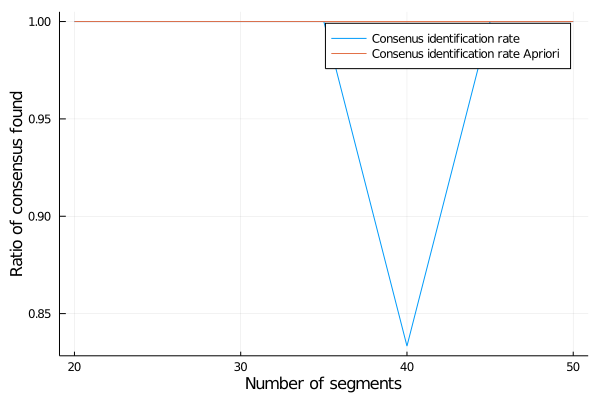

In [123]:
plot(x_val, [y_val2["avg_consensus_found_rate_arr"], y_val32["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate" "Consenus identification rate Apriori"], ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph C10

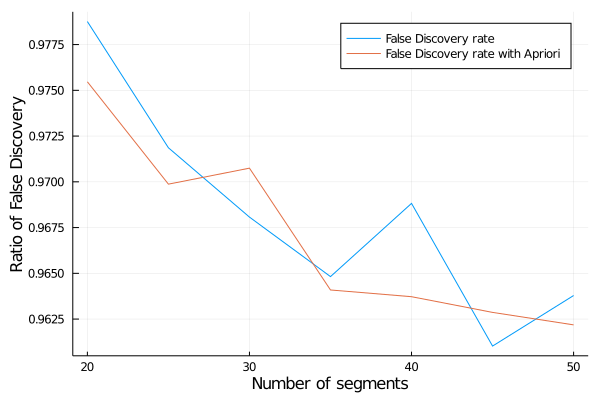

In [124]:
plot(x_val, [y_val2["avg_false_discovery_rate_arr"], y_val32["avg_false_discovery_rate_arr"]], label = ["False Discovery rate" "False Discovery rate with Apriori"], ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph C11

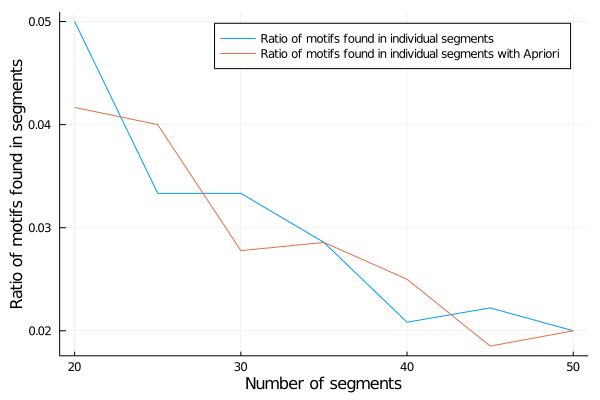

In [125]:
plot(x_val, [y_val2["avg_motifs_found_in_segments_ratio_arr"], y_val32["avg_motifs_found_in_segments_ratio_arr"]], label = ["Ratio of motifs found in individual segments" "Ratio of motifs found in individual segments with Apriori"], ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph C12

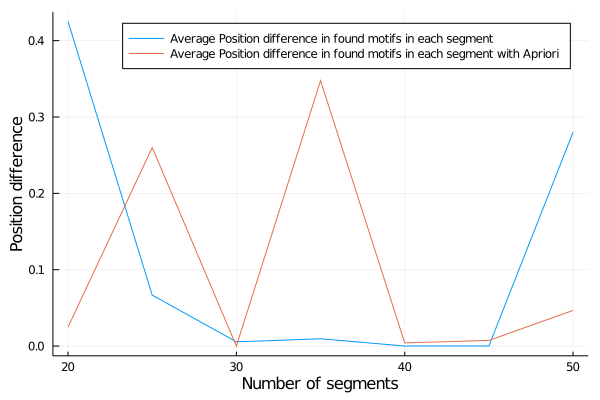

In [126]:
plot(x_val, [y_val2["avg_motifs_found_in_segments_position_error_arr"], y_val32["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment" "Average Position difference in found motifs in each segment with Apriori"], ylabel = "Position difference", xlabel=x_label)

#### Varying the DNA length

In [129]:
t = 10

y_val33 = Dict()
y_val33["times"] = []
y_val33["memory"] = []
y_val33["avg_consensus_found_rate_arr"] = []
y_val33["avg_false_discovery_rate_arr"] = []
y_val33["avg_motifs_found_in_segments_ratio_arr"] = []
y_val33["avg_motifs_found_in_segments_position_error_arr"] = []

for l in l_range
    
    average_time = 0
    average_memory = 0
    avg_consensus_found_rate = 0
    avg_false_discovery_rate = 0
    avg_motifs_found_in_segments_ratio = 0
    avg_motifs_found_in_segments_position_error = 0
    
    for c in 1:exp_count
        (positions, motifs, dna) = Arti_DNA(t, l, k, d, gc, m)
        meta_data = Dict()
        meta_data["motif_positions"] = positions
        meta_data["motifs"] = motifs
        
        ((motifs, motif_positions), time, bytes) = @timed(pairmotif(dna, k, d_thres))
        result = Dict()
        result["motif_positions"] = motif_positions
        result["motifs"] = motifs
        (motifs, time_apriori, bytes_apriori) = @timed(apriori(motifs))
        
        time += time_apriori
        bytes += bytes_apriori
        
        (consensus_found_rate, false_discovery_rate, motifs_found_in_segments_ratio, motifs_found_in_segments_position_error) = run_results(result, meta_data, d, t)
        
        average_time += time
        average_memory += bytes
        avg_consensus_found_rate += consensus_found_rate
        avg_false_discovery_rate += false_discovery_rate
        avg_motifs_found_in_segments_ratio += motifs_found_in_segments_ratio
        avg_motifs_found_in_segments_position_error += motifs_found_in_segments_position_error
    end
    average_time = average_time/exp_count
    average_memory = average_memory/exp_count

    avg_consensus_found_rate = avg_consensus_found_rate/exp_count
    avg_false_discovery_rate = avg_false_discovery_rate/exp_count
    avg_motifs_found_in_segments_ratio = avg_motifs_found_in_segments_ratio/exp_count
    avg_motifs_found_in_segments_position_error = avg_motifs_found_in_segments_position_error/exp_count
    
    y_val33["times"] = [y_val33["times"]; average_time]
    y_val33["memory"] = [y_val33["memory"]; average_memory]
    y_val33["avg_consensus_found_rate_arr"] = [y_val33["avg_consensus_found_rate_arr"]; avg_consensus_found_rate]
    y_val33["avg_false_discovery_rate_arr"] = [y_val33["avg_false_discovery_rate_arr"]; avg_false_discovery_rate]
    y_val33["avg_motifs_found_in_segments_ratio_arr"] = [y_val33["avg_motifs_found_in_segments_ratio_arr"]; avg_motifs_found_in_segments_ratio]
    y_val33["avg_motifs_found_in_segments_position_error_arr"] = [y_val33["avg_motifs_found_in_segments_position_error_arr"]; avg_motifs_found_in_segments_position_error]
end

x_val = l_range
x_label = "Length of DNA segments"

"Length of DNA segments"

## Graph C13

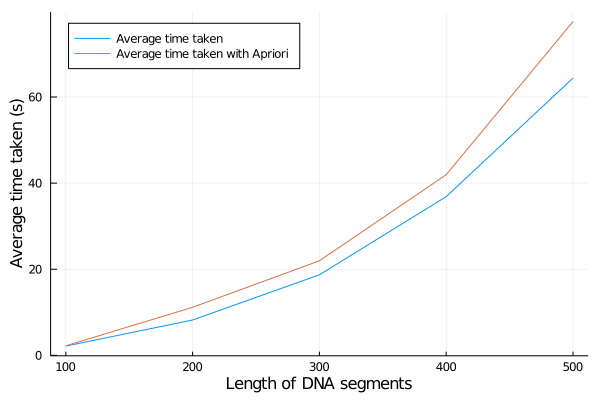

In [132]:
plot(x_val, [y_val3["times"], y_val33["times"]], label = ["Average time taken" "Average time taken with Apriori"], legend=:topleft, ylabel = "Average time taken (s)", xlabel=x_label)

## Graph C14

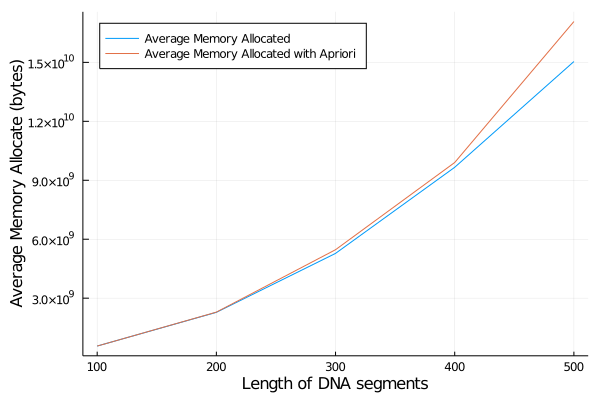

In [133]:
plot(x_val, [y_val3["memory"], y_val33["memory"]], label = ["Average Memory Allocated" "Average Memory Allocated with Apriori"], legend=:topleft, ylabel = "Average Memory Allocate (bytes)", xlabel=x_label)

## Graph C15

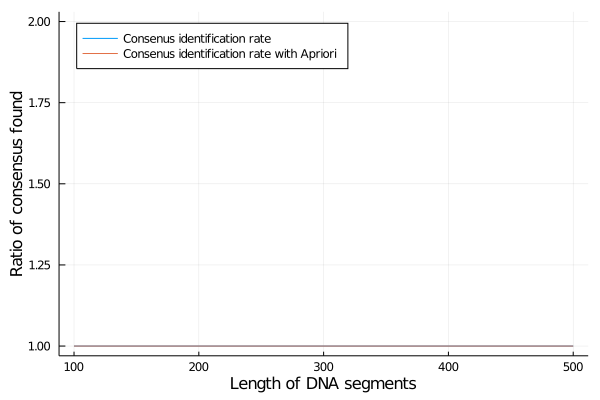

In [134]:
plot(x_val, [y_val3["avg_consensus_found_rate_arr"], y_val33["avg_consensus_found_rate_arr"]], label = ["Consenus identification rate" "Consenus identification rate with Apriori"], legend=:topleft, ylabel = "Ratio of consensus found", xlabel=x_label)

## Graph C16

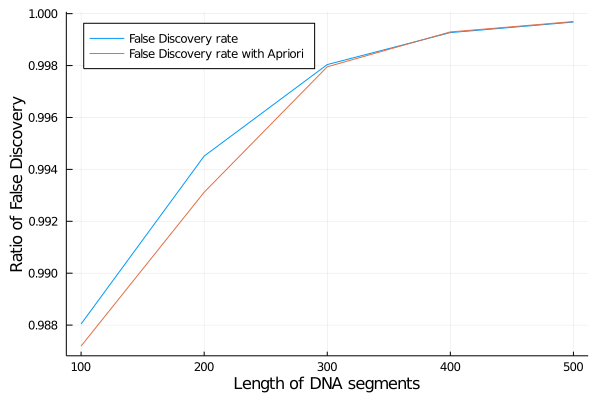

In [136]:
plot(x_val, [y_val3["avg_false_discovery_rate_arr"], y_val33["avg_false_discovery_rate_arr"]], label = ["False Discovery rate" "False Discovery rate with Apriori"], legend=:topleft, ylabel = "Ratio of False Discovery", xlabel=x_label)

## Graph C17

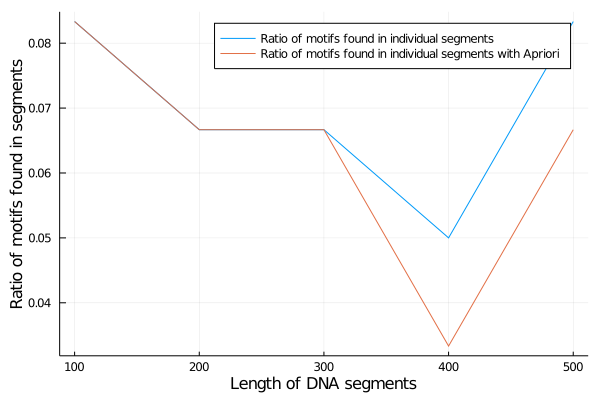

In [137]:
plot(x_val, [y_val3["avg_motifs_found_in_segments_ratio_arr"], y_val33["avg_motifs_found_in_segments_ratio_arr"]], label = ["Ratio of motifs found in individual segments" "Ratio of motifs found in individual segments with Apriori"], ylabel = "Ratio of motifs found in segments", xlabel=x_label)

## Graph C18

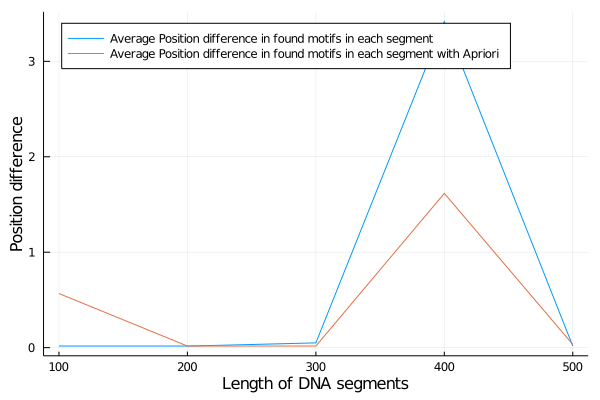

In [140]:
plot(x_val, [y_val3["avg_motifs_found_in_segments_position_error_arr"], y_val33["avg_motifs_found_in_segments_position_error_arr"]], label = ["Average Position difference in found motifs in each segment" "Average Position difference in found motifs in each segment with Apriori"], legend=:topleft, ylabel = "Position difference", xlabel=x_label)